In [1]:
""" Import Package """
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.decomposition import PCA
import os
import random
from tqdm import tqdm
import wandb
from sklearn.preprocessing import PolynomialFeatures
import time
import copy
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

""" Global variables """
DATA = "./data"
TRAIN_DATA_PATH = f"{DATA}/training.csv"
TEST_DATA_PATH = f"{DATA}/test.csv"
OUTPUT_PREDICTION = f"{DATA}/traditional_method_predictions.csv"

First, we want to find the relationthips among the features in the dataset in order to help us decide how to utilize the combination of features.

In [40]:
""" Visualize the relationships among features """
'''train_dataset = pd.read_csv(TRAIN_DATA_PATH)

features = train_dataset[['query_length', 'is_homepage', 'sig1', 'sig2', 
                          'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']]
sns.pairplot(features)
plt.show()'''

"train_dataset = pd.read_csv(TRAIN_DATA_PATH)\n\nfeatures = train_dataset[['query_length', 'is_homepage', 'sig1', 'sig2', \n                          'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']]\nsns.pairplot(features)\nplt.show()"

In [2]:
""" Load dataset """
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

features = ['query_length', 'is_homepage', 'sig1', 'sig2', 
            'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
train_features = train_data[features]
train_labels = train_data['relevance']
test_features = test_data[features]

print(train_features.shape)
print(train_labels.shape)

(80046, 10)
(80046,)


In [3]:
# standardize both dataset 
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [43]:
""" Visualize the relationships between features and relevance after preprocessing """
feature_list = ['query_length', 'is_homepage', 'sig1', 'sig2', 
                'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
features = pd.DataFrame(train_features)
labels = pd.DataFrame(train_labels)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for i, column in enumerate(features.columns):
    row, col = divmod(i, 2)
    axes[row, col].scatter(features[column], labels, alpha=0.5)
    axes[row, col].set_title(f'{feature_list[i]} vs Relevance')
    axes[row, col].set_xlabel(feature_list[i])
    axes[row, col].set_ylabel('Relevance')

plt.show()

"feature_list = ['query_length', 'is_homepage', 'sig1', 'sig2', \n                'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']\nfeatures = pd.DataFrame(train_features)\nlabels = pd.DataFrame(train_labels)\n\nfig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))\nfig.tight_layout(pad=5.0)\n\nfor i, column in enumerate(features.columns):\n    row, col = divmod(i, 2)\n    axes[row, col].scatter(features[column], labels, alpha=0.5)\n    axes[row, col].set_title(f'{feature_list[i]} vs Relevance')\n    axes[row, col].set_xlabel(feature_list[i])\n    axes[row, col].set_ylabel('Relevance')\n\nplt.show()"

In [4]:
""" Remove the outlier inside dataset """
features_df = pd.DataFrame(train_features)
Q1 = features_df.quantile(0.25)
Q3 = features_df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

original_sample_num = train_features.shape[0]

outlier_mask = (features_df < lower_bound) | (features_df > upper_bound)
outlier_count = outlier_mask.sum(axis=1)
outlier_threshold = 5
mask = outlier_count <= outlier_threshold

train_features = train_features[mask.values]
train_labels = train_labels[mask.values]
washed_sample_num = train_features.shape[0]
print(f"We remove {original_sample_num - washed_sample_num} outliers from dataset")
print(f"Currently we have {washed_sample_num} total samples")

We remove 23 outliers from dataset
Currently we have 80023 total samples


In [4]:
""" Apply kernel method to increase features """
poly = PolynomialFeatures(degree=2, include_bias=False)
train_features = poly.fit_transform(train_features)
test_features = poly.transform(test_features)

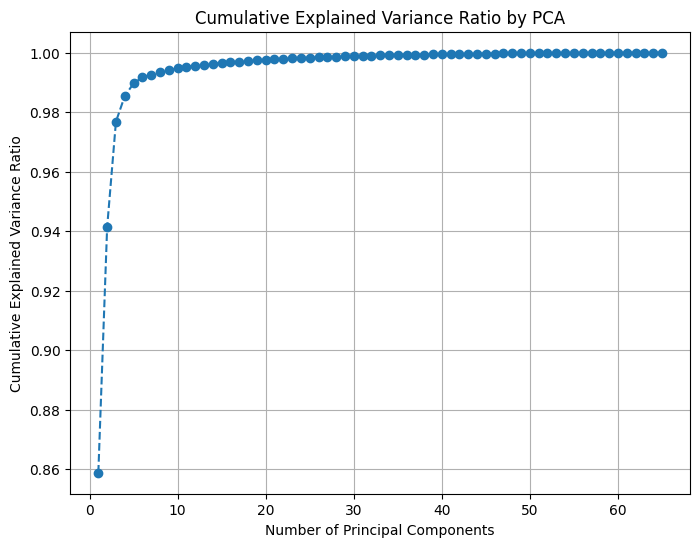

Number of principal components to retain (99% variance): 32


In [5]:
""" Apply PCA to remove unnecessary features """
pca = PCA()
pca.fit(train_features)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by PCA')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_variance_ratio >= 0.999) + 1
print(f"Number of principal components to retain (99% variance): {n_components}")

pca = PCA(n_components=n_components)
train_features = pca.fit_transform(train_features)
test_features = pca.transform(test_features)

In [47]:
""" Visualize the relationships between features and relevance after preprocessing """
features = pd.DataFrame(train_features)
labels = pd.DataFrame(train_labels)
if features.shape[1] < 20:
    fig, axes = plt.subplots(nrows=features.shape[1], figsize=(5, 5 * features.shape[1]))
    fig.tight_layout(pad=5.0)

    for i, column in enumerate(features.columns):
        axes[i].scatter(features[column], labels, alpha=0.5)
        axes[i].set_title(f'Signal {i} vs Relevance')
        axes[i].set_xlabel(f"Signal {i}")
        axes[i].set_ylabel('Relevance')

    plt.show()

'features = pd.DataFrame(train_features)\nlabels = pd.DataFrame(train_labels)\nif features.shape[1] < 20:\n    fig, axes = plt.subplots(nrows=features.shape[1], figsize=(5, 5 * features.shape[1]))\n    fig.tight_layout(pad=5.0)\n\n    for i, column in enumerate(features.columns):\n        axes[i].scatter(features[column], labels, alpha=0.5)\n        axes[i].set_title(f\'Signal {i} vs Relevance\')\n        axes[i].set_xlabel(f"Signal {i}")\n        axes[i].set_ylabel(\'Relevance\')\n\n    plt.show()'

In [ ]:
""" Apply forward stepwise feature selection """
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

all_features = ['query_length', 'is_homepage', 'sig1', 'sig2', 
                'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
optimal_features = []
optimal_cur_features = []
optimal_pre_features = []
best_acc = 0
for idx in range(len(all_features)):
    best_cur_acc = 0
    for new_feature in all_features:
        cur_features = optimal_pre_features[:]
        if new_feature not in optimal_pre_features:
            cur_features.append(new_feature)
        else:
            continue

        spline_transformer = SplineTransformer(n_knots=100, degree=3)
        model = LogisticRegression(random_state=1)
        pipeline = make_pipeline(spline_transformer, model)

        kf = KFold(n_splits=10, shuffle=True, random_state=1)

        cv_scores = cross_val_score(pipeline, train_features, train_labels, cv=kf, scoring='accuracy')
        
        if best_cur_acc <= np.mean(cv_scores):
            optimal_cur_features = cur_features
            best_cur_acc = np.mean(cv_scores)
    optimal_pre_features = optimal_cur_features
    if best_acc <= best_cur_acc:
        optimal_features = optimal_cur_features
        best_acc = best_cur_acc
print(f"Optimal features combination: {optimal_features} with best acc: {best_acc}")

In [4]:
""" Modeling using logistic regression  """
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold

model = LogisticRegression(
    random_state=1,
)

param_grid = [
    {
        'penalty': ['l2'], 
        'C': [0.01, 0.1, 1, 10, 100], 
        'solver': ['newton-cg', 'lbfgs', 'sag'], 
        'max_iter': [100, 300, 500]
    },
    {
        'penalty': ['l1'], 
        'C': [0.01, 0.1, 1, 10, 100], 
        'solver': ['liblinear'], 
        'max_iter': [100, 300, 500]
    },
    {
        'penalty': ['elasticnet'], 
        'C': [0.01, 0.1, 1, 10, 100], 
        'solver': ['saga'], 
        'l1_ratio': [0.2, 0.5, 0.8],  # Adding l1_ratio for elasticnet
        'max_iter': [100, 300, 500]
    },
    {
        'penalty': [None], 
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
        'max_iter': [100, 300, 500]
    }
]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=KFold(n_splits=5, shuffle=True, random_state=1), 
    verbose=1,
    n_jobs=-1
)

grid_search.fit(train_features, train_labels)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model.fit(train_features, train_labels)

Fitting 5 folds for each of 117 candidates, totalling 585 fits


In [5]:
""" Modeling using RandomForest Classifier  """
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

model = RandomForestClassifier(
    random_state=1,
)

param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=KFold(n_splits=5, shuffle=True, random_state=1), 
    verbose=1,
    n_jobs=-1
)

grid_search.fit(train_features, train_labels)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model.fit(train_features, train_labels)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\A\anaconda3\envs\Pytorch\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
159 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\A\anaconda3\envs\Pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\A\anaconda3\envs\Pytorch\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\A\anaconda3\envs\Pytorch\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\U

Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy:  0.6659420448577313


RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=1)

In [6]:
""" Modeling using Light Gradient Boosting  """
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV

model = lgb.LGBMClassifier(
    random_state=1,
    verbosity=-1,
)

param_grid = {
    'num_leaves': [31],
    'max_depth': [-1],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'min_child_samples': [20],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=KFold(n_splits=5, shuffle=True, random_state=1), 
    verbose=1,
    n_jobs=-1
)

grid_search.fit(train_features, train_labels)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model.fit(train_features, train_labels)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Exception in thread Thread-9:
Traceback (most recent call last):
  File "c:\Users\A\anaconda3\envs\Pytorch\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\A\anaconda3\envs\Pytorch\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\A\anaconda3\envs\Pytorch\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\A\anaconda3\envs\Pytorch\lib\subprocess.py", line 1495, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\A\anaconda3\envs\Pytorch\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbf in position 24: invalid start byte
c:\Users\A\anaconda3\envs\Pytorch\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has n

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}
Best cross-validation accuracy:  0.658683697946451


LGBMClassifier(colsample_bytree=0.8, random_state=1, subsample=0.8,
               verbosity=-1)

In [4]:
""" Predict on test dataset using the best model """
results = []
predictions = best_model.predict(test_features)
for idx, prediction in enumerate(predictions):
    sample_id = str(int(test_data.iloc[idx]['query_id'])) + str(int(test_data.iloc[idx]['url_id']))
    results.append({'id': sample_id, 'relevance': int(prediction)})

results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_PREDICTION, index=False)
print(f"Predictions saved at {OUTPUT_PREDICTION}")

Predictions saved at ./data/traditional_method_predictions.csv
